<a href="https://colab.research.google.com/github/yyuukkee/Algorithmic-Trading-and-High-Frequency-Finance/blob/main/Evaluating%20Trading%20Strategies%20Using%20Technical%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Evaluating Trading Strategies Using Technical Analysis

##Project Objective
The goal of this project is to develop and evaluate technical trading strategies using at least four years of historical market data (stocks, indices, or ETFs). The strategy's performance will be assessed by key metrics such as total return, winning percentage, and maximum drawdown.



##Step 1: Select the asset and download the data

In this step, we chose the Nasdaq Composite Index for research and the Invesco QQQ ETF as the research asset. We choose to study the Invesco QQQ ETF (QQQ) using data from January 1, 2020, to January 1, 2025, covering a five-year period. The Nasdaq Composite Index is one of the most widely followed stock market indices, tracking over 3,000 technology-heavy stocks listed on the Nasdaq Stock Exchange. It is known for its high-growth companies in sectors such as technology, biotechnology, and communications, including giants like Apple, Microsoft, Amazon, and NVIDIA. To conduct our analysis, we select Invesco QQQ ETF (Ticker: QQQ), an exchange-traded fund (ETF) designed to track the Nasdaq-100 Index. QQQ includes the top 100 non-financial companies listed on Nasdaq, making it a widely used vehicle for investors looking to gain exposure to high-growth technology firms.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
ticker = "QQQ"
start_date = "2020-01-01"
end_date = "2025-01-01"

qqq_data = yf.download(ticker, start=start_date, end=end_date, interval="1d",auto_adjust=False)
qqq_data = qqq_data.droplevel(1, axis=1)
print()
print(qqq_data.head())
print(qqq_data.tail())

[*********************100%***********************]  1 of 1 completed


Price        Adj Close       Close        High         Low        Open  \
Date                                                                     
2020-01-02  209.638031  216.160004  216.160004  213.979996  214.399994   
2020-01-03  207.717819  214.179993  215.470001  213.279999  213.300003   
2020-01-06  209.056152  215.559998  215.589996  212.240005  212.500000   
2020-01-07  209.027069  215.529999  216.139999  214.850006  215.639999   
2020-01-08  210.598160  217.149994  218.139999  215.160004  215.500000   

Price         Volume  
Date                  
2020-01-02  30969400  
2020-01-03  27518900  
2020-01-06  21655300  
2020-01-07  22139300  
2020-01-08  26397300  
Price        Adj Close       Close        High         Low        Open  \
Date                                                                     
2024-12-24  529.960022  529.960022  530.049988  524.190002  524.830017   
2024-12-26  529.599976  529.599976  531.239990  526.309998  528.320007   
2024-12-27  522.559998 

##Step 2: Strategy Design

### Trading System Assumptions(Filter rules)

#### Initial Capital
$100,000

#### Trading Unit
Only whole shares can be bought or sold.

#### Trading Logic
- Buy Condition:  
  - The current closing price breaks above \( 1.05M_k \) (the highest price in the past 10 days).  
  - There is sufficient capital to buy at least 1 share.  

- Sell Condition:  
  - The current closing price falls below \( 0.95m_k \) (the lowest price in the past 10 days).  
  - The account holds shares.

#### Capital Management
- Buying: Purchase as many whole shares as possible, but borrowing is not allowed.  
- Selling: Liquidate all holdings.  
- Management Fee: A 0.20% per year fee is deducted from the total capital.  

#### Slippage Settings
A slippage factor is introduced to simulate real market conditions:
- Fixed Slippage: A predefined percentage (0.05% per trade).  





In [3]:
n = 10
qqq_data["M_k"] = qqq_data["Close"].rolling(window=n).max()
qqq_data["m_k"] = qqq_data["Close"].rolling(window=n).min()
print(qqq_data.head())
print(qqq_data.tail())

Price        Adj Close       Close        High         Low        Open  \
Date                                                                     
2020-01-02  209.638031  216.160004  216.160004  213.979996  214.399994   
2020-01-03  207.717819  214.179993  215.470001  213.279999  213.300003   
2020-01-06  209.056152  215.559998  215.589996  212.240005  212.500000   
2020-01-07  209.027069  215.529999  216.139999  214.850006  215.639999   
2020-01-08  210.598160  217.149994  218.139999  215.160004  215.500000   

Price         Volume  M_k  m_k  
Date                            
2020-01-02  30969400  NaN  NaN  
2020-01-03  27518900  NaN  NaN  
2020-01-06  21655300  NaN  NaN  
2020-01-07  22139300  NaN  NaN  
2020-01-08  26397300  NaN  NaN  
Price        Adj Close       Close        High         Low        Open  \
Date                                                                     
2024-12-24  529.960022  529.960022  530.049988  524.190002  524.830017   
2024-12-26  529.599976  529.

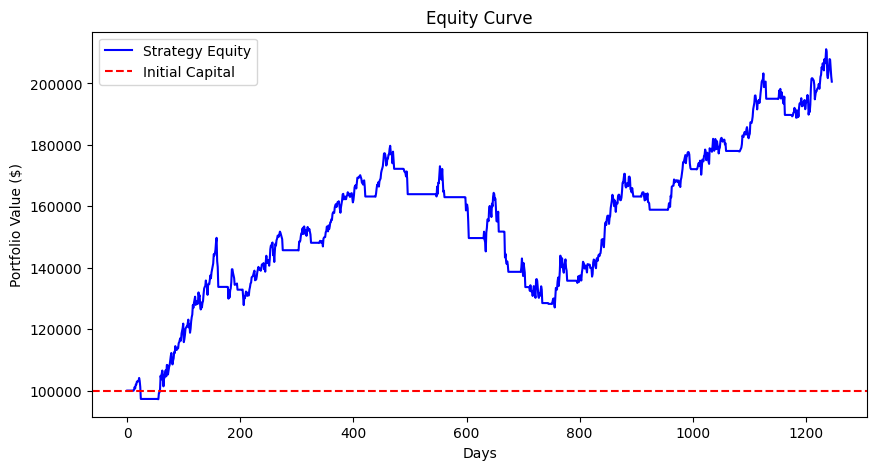

In [4]:
initial_capital = 100000
cash = initial_capital
position = 0
buy_threshold = 1.01
sell_threshold = 0.99
slippage = 0.0005
management_fee = 0.002

trade_log = []
equity_curve = []
round_trip_trades = 0
winning_trades = 0
losing_trades = 0
entry_price = 0
drawdowns = []

for i in range(n+1, len(qqq_data)):
    current_price = qqq_data["Close"].iloc[i]
    current_price_adjust=qqq_data["Adj Close"].iloc[i]
    max_price = qqq_data["M_k"].iloc[i-1]
    min_price = qqq_data["m_k"].iloc[i-1]

    buy_signal = current_price > buy_threshold * max_price
    sell_signal = current_price < sell_threshold * min_price

    if buy_signal and cash >= current_price:
        execution_price = current_price * (1 + slippage)
        shares_to_buy = int(cash / execution_price)
        cost = shares_to_buy * execution_price
        position += shares_to_buy
        cash -= cost
        entry_price = execution_price
        entry_price_adjust=current_price_adjust
        trade_log.append(f"Buy {shares_to_buy} shares at {execution_price:.2f} on {qqq_data.index[i].date()}")

    elif sell_signal and position > 0:
        execution_price = entry_price * current_price_adjust / entry_price_adjust * (1 - slippage)
        cash += position * execution_price

        round_trip_trades += 1
        if execution_price > entry_price:
            winning_trades += 1
        else:
            losing_trades += 1

        trade_log.append(f"Sell {position} shares at {execution_price:.2f} on {qqq_data.index[i].date()}")
        position = 0

    if i % 252 == 0:
        cash *= (1 - management_fee)

    current_equity = cash + position * current_price
    equity_curve.append(current_equity)

    peak = max(equity_curve)
    drawdown = (peak - current_equity) / peak
    drawdowns.append(drawdown)

final_value = cash + position * qqq_data["Close"].iloc[-1]
trade_log.append(f"Final Portfolio Value: ${final_value:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(equity_curve, label="Strategy Equity", color="blue")
plt.axhline(y=initial_capital, color='r', linestyle='--', label="Initial Capital")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.title("Equity Curve")
plt.legend()
plt.show()

In [5]:
for i, log in enumerate(trade_log, 1):
    print(log, end="  ")
    if i % 2 == 0:
        print()

Buy 439 shares at 227.58 on 2020-02-04  Sell 439 shares at 221.39 on 2020-02-24  
Buy 494 shares at 196.58 on 2020-04-06  Sell 494 shares at 270.42 on 2020-09-08  
Buy 473 shares at 282.39 on 2020-10-01  Sell 473 shares at 280.47 on 2020-10-26  
Buy 451 shares at 294.54 on 2020-11-05  Sell 451 shares at 323.02 on 2021-02-22  
Buy 448 shares at 324.73 on 2021-04-01  Sell 448 shares at 330.14 on 2021-05-04  
Buy 445 shares at 332.68 on 2021-05-24  Sell 445 shares at 366.53 on 2021-09-20  
Buy 444 shares at 366.81 on 2021-10-14  Sell 444 shares at 387.12 on 2021-12-01  
Buy 426 shares at 403.68 on 2021-12-27  Sell 426 shares at 384.29 on 2022-01-05  
Buy 466 shares at 351.67 on 2022-03-18  Sell 466 shares at 349.58 on 2022-04-08  
Buy 518 shares at 314.54 on 2022-06-02  Sell 518 shares at 288.84 on 2022-06-10  
Buy 493 shares at 303.18 on 2022-07-20  Sell 493 shares at 307.44 on 2022-08-26  
Buy 488 shares at 310.90 on 2022-09-12  Sell 488 shares at 284.07 on 2022-09-21  
Buy 503 shares a

### Step 3: Calculating Trading Performance Metrics

#### Core Objectives
1. Calculate key performance indicators (KPIs):
   - Total return (%): Measures the overall return from the strategy
   - Buy and hold return (%): Compares performance with a simple buy-and-hold strategy
   - Number of round-trip trades: Counts the completed buy-sell cycles
   - Winning trades (%): Percentage of trades that resulted in a profit
   - Maximum drawdown (%): The maximum observed loss from a peak to a trough

2. Display performance metrics table:
   


In [6]:
final_value = cash + position * qqq_data["Close"].iloc[-1]
trade_log.append(f"Final Portfolio Value: ${final_value:.2f}")

total_return = ((final_value - initial_capital) / initial_capital) * 100
buy_and_hold_return = ((qqq_data["Adj Close"].iloc[-1] - qqq_data["Adj Close"].iloc[0]) / qqq_data["Adj Close"].iloc[0]) * 100
win_rate = (winning_trades / round_trip_trades) * 100 if round_trip_trades > 0 else 0
max_drawdown = max(drawdowns) * 100

performance_data = {
    "Sample": ["Historical"],
    "# of round-trip trades": [round_trip_trades],
    "Total return, %": [round(total_return, 2)],
    "B & H return, %": [round(buy_and_hold_return, 2)],
    "Winning trades, %": [round(win_rate, 2)],
    "Max drawdown, %": [round(max_drawdown, 2)]
}

performance_df = pd.DataFrame(performance_data)
print(performance_df)

       Sample  # of round-trip trades  Total return, %  B & H return, %  \
0  Historical                      21           100.57           143.86   

   Winning trades, %  Max drawdown, %  
0              52.38            29.29  


The trading performance results show that the strategy executed 21 round-trip trades, yielding a total return of 100.57%.  However, this is notably lower than the buy-and-hold return of 143.86% over the same period.  The underperformance could be attributed to the sustained upward trend of the Invesco QQQ ETF, where remaining out of the market led to missed opportunities.  With a winning trade percentage of 52.38%, the strategy demonstrated only a slight edge over random chance.  Additionally, the maximum drawdown of 29.29% highlights considerable downside risk, indicating that the portfolio experienced a significant decline at some point.  While the strategy generated reasonable returns, its underperformance relative to a simple buy-and-hold approach suggests it may not be the most attractive option for long-term investors.

##Other Strategy

### Moving Average Trading Strategy

#### Strategy Assumptions
- Initial Capital: $100,000
- Trading Unit: Only whole shares can be bought or sold.

#### Trading Logic
#### Compute Moving Averages
- Short-Term Moving Average (SMA):  
  $$
  SMA(P_t, S) = \frac{(P_{t-1} + P_{t-2} + ... + P_{t-S})}{S}
  $$
- Long-Term Moving Average (SMA):  
  $$
  SMA(P_t, L) = \frac{(P_{t-1} + P_{t-2} + ... + P_{t-L})}{L}
  $$
- Signal Calculation:  
  $$
  r_t = \frac{SMA(P_t, S) - SMA(P_t, L)}{SMA(P_t, L)}
  $$

#### Trade Execution
- Buy Condition: When $$ r_t > \delta $$, indicating an uptrend.
- Sell Condition: When $$ r_t < -\delta$$, indicating a downtrend.

#### Capital Management
- Buy: Purchase as many whole shares as possible without borrowing.
- Sell: Liquidate all holdings when a sell signal is triggered.
- Management Fee: A 0.20% annual fee is deducted from the total capital.
- Slippage Settings:
  - Fixed Slippage: A predefined percentage (0.05% per trade).
  


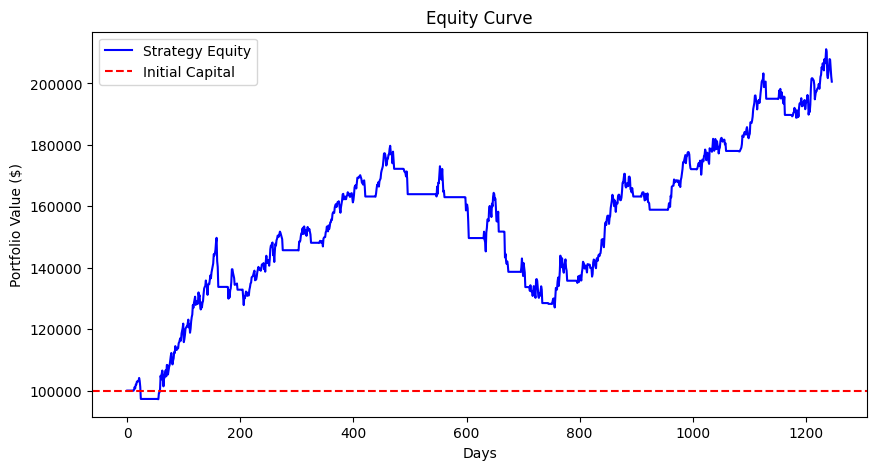

In [7]:
short_window = 5
long_window = 20
buy_threshold = 0.001
sell_threshold = -0.001
initial_capital = 100000
slippage = 0.0005
management_fee = 0.002

qqq_data["SMA_S"] = qqq_data["Close"].rolling(window=short_window).mean()
qqq_data["SMA_L"] = qqq_data["Close"].rolling(window=long_window).mean()
qqq_data["Signal"] = (qqq_data["SMA_S"] - qqq_data["SMA_L"]) / qqq_data["SMA_L"]


cash = initial_capital
position = 0
trade_log = []
winning_trades = 0
round_trip_trades = 0
peak_value = initial_capital
drawdowns = []

for i in range(long_window, len(qqq_data)):
    current_price = qqq_data["Close"].iloc[i]
    current_price_adjust=qqq_data["Adj Close"].iloc[i]
    signal = qqq_data["Signal"].iloc[i]

    buy_signal = signal > buy_threshold
    sell_signal = signal < sell_threshold

    if buy_signal and cash >= current_price:
        execution_price = current_price * (1 + slippage)
        shares_to_buy = int(cash / execution_price)
        cost = shares_to_buy * execution_price
        position += shares_to_buy
        cash -= cost
        entry_price = execution_price
        entry_price_adjust=current_price_adjust
        trade_log.append(f"Buy {shares_to_buy} shares at {execution_price:.2f} on {qqq_data.index[i].date()}")

    elif sell_signal and position > 0:
        execution_price = entry_price * current_price_adjust / entry_price_adjust * (1 - slippage)
        sell_value = position * execution_price
        cash += sell_value
        trade_log.append(f"Sell {shares_to_buy} shares at {execution_price:.2f} on {qqq_data.index[i].date()}")

        if execution_price > entry_price:
            winning_trades += 1
        round_trip_trades += 1
        position = 0

    current_value = cash + position * current_price
    peak_value = max(peak_value, current_value)
    drawdowns.append((peak_value - current_value) / peak_value)

    if i % 252 == 0:
        cash *= (1 - management_fee)

final_value = cash + position * qqq_data["Close"].iloc[-1]
trade_log.append(f"Final Portfolio Value: ${final_value:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(equity_curve, label="Strategy Equity", color="blue")
plt.axhline(y=initial_capital, color='r', linestyle='--', label="Initial Capital")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.title("Equity Curve")
plt.legend()
plt.show()

In [8]:
for i, log in enumerate(trade_log, 1):
    print(log, end="  ")
    if i % 2 == 0:
        print()

Buy 456 shares at 219.18 on 2020-01-31  Sell 456 shares at 215.37 on 2020-02-25  
Buy 538 shares at 182.40 on 2020-04-01  Sell 538 shares at 260.22 on 2020-07-29  
Buy 519 shares at 269.51 on 2020-08-03  Sell 519 shares at 272.34 on 2020-09-10  
Buy 501 shares at 282.39 on 2020-10-01  Sell 501 shares at 282.66 on 2020-10-27  
Buy 490 shares at 288.73 on 2020-11-09  Sell 490 shares at 324.72 on 2021-02-24  
Buy 494 shares at 322.06 on 2021-03-17  Sell 494 shares at 330.56 on 2021-05-04  
Buy 489 shares at 334.30 on 2021-05-26  Sell 489 shares at 364.38 on 2021-08-19  
Buy 475 shares at 374.56 on 2021-08-24  Sell 475 shares at 373.83 on 2021-09-17  
Buy 477 shares at 372.84 on 2021-10-18  Sell 477 shares at 387.12 on 2021-12-01  
Buy 470 shares at 392.46 on 2021-12-13  Sell 470 shares at 388.20 on 2021-12-14  
Buy 452 shares at 403.68 on 2021-12-27  Sell 452 shares at 384.02 on 2022-01-06  
Buy 496 shares at 350.26 on 2022-03-21  Sell 496 shares at 340.89 on 2022-04-11  
Buy 552 shares a

In [9]:
max_drawdown = max(drawdowns) * 100
win_rate = (winning_trades / round_trip_trades) * 100 if round_trip_trades > 0 else 0

total_return = ((final_value - initial_capital) / initial_capital) * 100

performance_data = {
    "Sample": ["Historical"],
    "# of round-trip trades": [round_trip_trades],
    "Total return, %": [round(total_return, 2)],
    "B & H return, %": [round(buy_and_hold_return, 2)],
    "Winning trades, %": [round(win_rate, 2)],
    "Max drawdown, %": [round(max_drawdown, 2)]
}

performance_df = pd.DataFrame(performance_data)
print(performance_df)

       Sample  # of round-trip trades  Total return, %  B & H return, %  \
0  Historical                      29           122.04           143.86   

   Winning trades, %  Max drawdown, %  
0              55.17            23.57  


The trading strategy executed 29 round-trip trades, achieving a total return of 122.04%.  While this represents a solid performance, it remains below the buy-and-hold return of 143.86% over the same period.  This indicates that the frequent trading approach did not surpass the returns of simply holding the asset.  The win rate of 55.17% suggests a moderate edge in trade profitability, while the maximum drawdown of 23.57% reflects a relatively controlled level of downside risk compared to previous iterations.  Overall, while the strategy effectively mitigates risk and delivers respectable returns, its inability to outperform the buy-and-hold approach may limit its attractiveness for long-term investors.

### Channel breakouts Trading Strategy
#### Strategy Assumptions
- Initial Capital: $100,000
- Trading Unit: Only whole shares can be bought or sold.

#### Trading Logic

The upper and lower bands are calculated using the highest (M_t) and lowest (m_t) prices over a rolling window (window = 20).
The standard deviation (stddev) of the closing price over the same window is computed.
The threshold (B) is determined as k * stddev, where k = 2, a typical Bollinger Band setting.

- Buy Condition: If the price breaks above (1 + B) * m_prev, it indicates an uptrend breakout, and the strategy buys as many whole shares as possible.

- Sell Condition: If the price falls below (1 - B) * M_prev, it indicates a downtrend breakout, and the strategy sells all holdings.

#### Capital Management
- Buy: Purchase as many whole shares as possible without borrowing.
- Sell: Liquidate all holdings when a sell signal is triggered.
- Management Fee: A 0.20% annual fee is deducted from the total capital.
- Slippage Settings:
  - Fixed Slippage: A predefined percentage (0.05% per trade).

In [10]:
window = 20
qqq_data["M_t"] = qqq_data["High"].rolling(window=window).max()
qqq_data["m_t"] = qqq_data["Low"].rolling(window=window).min()
qqq_data["stddev"] = qqq_data["Close"].rolling(window=window).std()

k = 2
initial_capital = 100000
cash = initial_capital
position = 0
slippage = 0.0005
management_fee = 0.002
round_trip_trades = 0
winning_trades = 0
drawdowns = []
peak_value = initial_capital

trade_log = []

for i in range(window, len(qqq_data)):
    current_price = qqq_data["Close"].iloc[i]
    current_price_adjust=qqq_data["Adj Close"].iloc[i]
    M_prev = qqq_data["M_t"].iloc[i-1]
    m_prev = qqq_data["m_t"].iloc[i-1]
    B= k * qqq_data["stddev"].iloc[i-1]
    buy_price = (1 + B) * m_prev
    sell_price = (1 - B) * M_prev

    if position == 0 and current_price > buy_price and cash >= current_price:
        execution_price = current_price * (1 + slippage)
        shares_to_buy = int(cash / execution_price)
        cost = shares_to_buy * execution_price
        position += shares_to_buy
        cash -= cost
        entry_price = execution_price
        entry_price_adjust=current_price_adjust
        trade_log.append(f"Buy {shares_to_buy} shares at {execution_price:.2f} on {qqq_data.index[i].date()}")

    elif position > 0 and current_price < sell_price:
        execution_price = entry_price * current_price_adjust / entry_price_adjust * (1 - slippage)
        sell_revenue = position * execution_price
        cash += sell_revenue
        trade_log.append(f"Sell {position} shares at {execution_price:.2f} on {qqq_data.index[i].date()}")


        if execution_price > entry_price:
            winning_trades += 1

        position = 0

    portfolio_value = cash + position * current_price
    peak_value = max(peak_value, portfolio_value)
    drawdown = (peak_value - portfolio_value) / peak_value * 100
    drawdowns.append(drawdown)

    if i % 252 == 0:
        cash *= (1 - management_fee)

final_value = cash + position * qqq_data["Close"].iloc[-1]
trade_log.append(f"Final Portfolio Value: ${final_value:.2f}")

total_return = ((final_value - initial_capital) / initial_capital) * 100
win_rate = (winning_trades / round_trip_trades) * 100 if round_trip_trades > 0 else 0
max_drawdown = max(drawdowns)

performance_data = {
    "Sample": ["Historical"],
    "# of round-trip trades": [round_trip_trades],
    "Total return, %": [round(total_return, 2)],
    "B & H return, %": [round(buy_and_hold_return, 2)],
    "Winning trades, %": [round(win_rate, 2)],
    "Max drawdown, %": [round(max_drawdown, 2)]
}

performance_df = pd.DataFrame(performance_data)

for log in trade_log:
    print(log)
print(performance_df)


Final Portfolio Value: $99202.40
       Sample  # of round-trip trades  Total return, %  B & H return, %  \
0  Historical                       0             -0.8           143.86   

   Winning trades, %  Max drawdown, %  
0                  0              0.8  


The strategy did not execute any trades, as indicated by the zero round-trip trades.  This suggests that the buy and sell conditions were never met.  The total return is -0.8%, due to the annual management fee, while the buy-and-hold return is 143.86%, showing that the ETF performed well, but the strategy failed to capture gains.

###Momentum and oscillator strategies

### Momentum and Oscillator Trading Strategy

#### Strategy Assumptions
- Initial Capital: `$100,000`
- Trading Unit: Only whole shares can be bought or sold.

#### Trading Logic
This strategy utilizes momentum (k-day price change) and MACD-based oscillator to generate buy and sell signals.

The k-day price momentum is computed as:

$$ M_t = P_t - P_{t-k} $$

where \( k = 10 \) days, indicating the net price change over the past 10 days.

#### MACD Oscillator Calculation
- The MACD line is computed as the difference between two exponential moving averages (EMA):
  
  $$ MACD_t = ema(P_t, 12) - ema(P_t, 26) $$
  
- A signal line is computed as the 9-day EMA of the MACD line:
  
  $$\text{Signal Line} = ema(MACD_t, 9) $$
  
- The oscillator is the difference between MACD and its signal line:
  
  \[ \text{Oscillator} = MACD_t - \text{Signal Line} \]

#### Trading Conditions
- Buy Condition: If the MACD crosses above the signal line, it indicates a bullish momentum shift, and the strategy buys as many whole shares as possible.
- Sell Condition: If the MACD crosses below the signal line, it indicates a bearish momentum shift, and the strategy sells all holdings.

#### Capital Management
- Buy: Purchase as many whole shares as possible without borrowing.
- Sell: Liquidate all holdings when a sell signal is triggered.
- Management Fee: A 0.20% annual fee is deducted from the total capital.
- Slippage Settings:
  - Fixed Slippage: A predefined percentage (0.05% per trade).



In [11]:
k_day = 10
ema_short = 12
ema_long = 26
signal_window = 9
initial_capital = 100000
slippage = 0.0005
management_fee = 0.002


qqq_data["Momentum"] = qqq_data["Close"] - qqq_data["Close"].shift(k_day)
qqq_data["EMA_12"] = qqq_data["Close"].ewm(span=ema_short, adjust=False).mean()
qqq_data["EMA_26"] = qqq_data["Close"].ewm(span=ema_long, adjust=False).mean()
qqq_data["MACD"] = qqq_data["EMA_12"] - qqq_data["EMA_26"]
qqq_data["Signal"] = qqq_data["MACD"].ewm(span=signal_window, adjust=False).mean()
qqq_data["Oscillator"] = qqq_data["MACD"] - qqq_data["Signal"]

cash = initial_capital
position = 0
trade_log = []
winning_trades = 0
round_trip_trades = 0
peak_value = initial_capital
drawdowns = []
equity_curve = []

for i in range(signal_window, len(qqq_data)):
    current_price = qqq_data["Close"].iloc[i]
    current_price_adjust=qqq_data["Adj Close"].iloc[i]
    macd = qqq_data["MACD"].iloc[i]
    signal = qqq_data["Signal"].iloc[i]

    buy_signal = macd > signal
    sell_signal = macd < signal

    if buy_signal and cash >= current_price:
        execution_price = current_price * (1 + slippage)
        shares_to_buy = int(cash / execution_price)
        cost = shares_to_buy * execution_price
        position += shares_to_buy
        cash -= cost
        entry_price = execution_price
        entry_price_adjust=current_price_adjust
        trade_log.append(f"Buy {shares_to_buy} shares at {execution_price:.2f} on {qqq_data.index[i].date()}")

    elif sell_signal and position > 0:
        execution_price = entry_price * current_price_adjust / entry_price_adjust * (1 - slippage)
        sell_value = position * execution_price
        cash += sell_value
        trade_log.append(f"Sell {position} shares at {execution_price:.2f} on {qqq_data.index[i].date()}")

        if execution_price > entry_price:
            winning_trades += 1
        round_trip_trades += 1
        position = 0

    current_value = cash + position * current_price
    equity_curve.append(current_value)
    peak_value = max(peak_value, current_value)
    drawdowns.append((peak_value - current_value) / peak_value)

    if i % 252 == 0:
        cash *= (1 - management_fee)

final_value = cash + position * qqq_data["Close"].iloc[-1]
trade_log.append(f"Final Portfolio Value: ${final_value:.2f}")

total_return = ((final_value - initial_capital) / initial_capital) * 100
win_rate = (winning_trades / round_trip_trades) * 100 if round_trip_trades > 0 else 0
max_drawdown = max(drawdowns) * 100

performance_data = {
    "Sample": ["Historical"],
    "# of round-trip trades": [round_trip_trades],
    "Total return, %": [round(total_return, 2)],
    "B & H return, %": [round(buy_and_hold_return, 2)],
    "Winning trades, %": [round(win_rate, 2)],
    "Max drawdown, %": [round(max_drawdown, 2)]
}

performance_df = pd.DataFrame(performance_data)
print(performance_df)




       Sample  # of round-trip trades  Total return, %  B & H return, %  \
0  Historical                      50            56.34           143.86   

   Winning trades, %  Max drawdown, %  
0               54.0            25.01  


The backtest results indicate that the Momentum and Oscillator Trading Strategy achieved a total return of 56.34%.  While the strategy was profitable, it significantly underperformed the buy-and-hold return of 143.86%, suggesting that simply holding the asset would have been a more effective approach during this period.  The strategy executed 50 round-trip trades, reflecting a high trading frequency.  With a winning trade rate of 54.0%, it does not rely heavily on a high success rate but likely depends on the risk-reward ratio of individual trades.  However, the maximum drawdown of 25.01% indicates notable downside risk, as the portfolio experienced a substantial decline from its peak.  Overall, while the strategy provides active trading opportunities, its inability to surpass the buy-and-hold return raises concerns about its long-term viability.

###Conclusion
In this project, we observed that none of the trading strategies outperformed the buy-and-hold approach in terms of return. This underperformance is likely due to the fact that QQQ has been in an overall upward trend for most of the period. As a result, the trading strategies missed out on a portion of the gains by entering and exiting positions. For assets that exhibit a consistent upward trajectory over time, a buy-and-hold strategy may generate higher returns compared to more active trading approaches.